# Loan Repayment Predictor

**Brief:**

41,029 rows of data, each one representing information on a funded loan.
The attribute `Outcome` indicates whether the loan has been paid off or defaulted.

Use some or all of the other columns, to build a predictive model to predict **whether the applicant would pay the loan back**. There are a total of **76 other attributes** which include information collected on the application form and information collected from the applicant's credit file at the time of origination.

You are free to use any predictive model you wish. We do not recommend spending more than 3-4 hours on the task. We would like you to perform this task in a Jupyter notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay 

In [2]:
df = pd.read_csv("loan-repayment-predictor/loan-info.csv")
df.head()

,borrower_id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,outcome,purpose,addr_state,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,537185,16075.0,60 months,NaN,NaN,MORTGAGE,50289.0,Fully Paid,home_improvement,SC,...,0.0,2.0,95.7,100.0,0.0,0,227376.0,15756.0,11900.0,6000.0
1,1810804,8000.0,36 months,Graydon Head & Ritchey LLP,10+ years,MORTGAGE,64000.0,Fully Paid,debt_consolidation,IN,...,0.0,0.0,100.0,75.0,1.0,0,121881.0,33618.0,13700.0,29400.0
2,388855,23700.0,36 months,Director of IT,3 years,RENT,88000.0,Fully Paid,debt_consolidation,FL,...,0.0,5.0,100.0,10.0,1.0,0,99201.0,58898.0,18700.0,69501.0
3,1137067,1200.0,36 months,NaN,NaN,MORTGAGE,81000.0,Fully Paid,other,NY,...,0.0,4.0,83.3,100.0,0.0,0,203983.0,20609.0,1100.0,26183.0
4,14585,3500.0,36 months,NaN,NaN,RENT,11736.0,Fully Paid,debt_consolidation,WA,...,0.0,1.0,100.0,100.0,1.0,0,16200.0,9459.0,2000.0,0.0


In [3]:
df.shape

(41029, 78)

# Data exploration and visualisation

### Exploring our target variable: 'Outcome'

From looking at our target variable `outcome` below, we can see there is a massive class imbalance. 

We can deduce from the graphic below that this is a **binary classification** problem.

<Axes: xlabel='count', ylabel='outcome'>

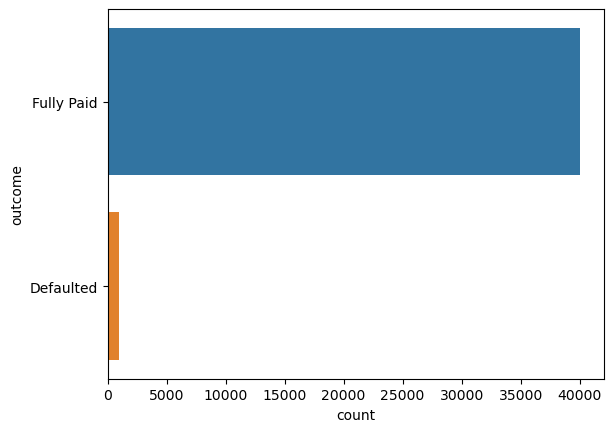

In [4]:
sns.countplot(y="outcome", data=df) # we can see below large majority of people paid back loan

In [5]:
df["outcome"].value_counts()

Fully Paid    40029
Defaulted      1000
Name: outcome, dtype: int64

### 'Loan Amount' feature

<Axes: xlabel='loan_amnt', ylabel='Count'>

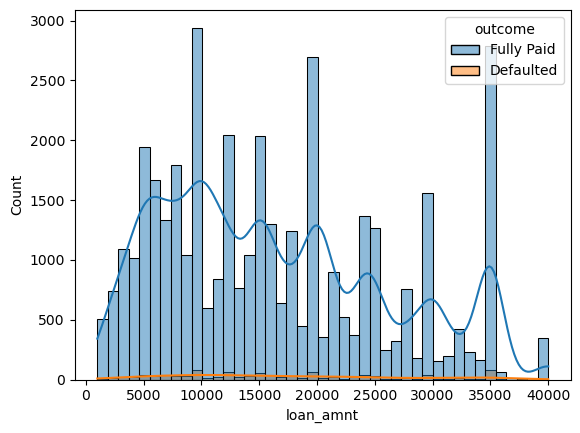

In [6]:
sns.histplot(x="loan_amnt", hue="outcome", data=df, kde=True) # orange line indicates even spread across data,
# meaning size of loan isn't big indicator whether loan will be paid back.

### 'Term' feature

In [7]:
df["term"].value_counts() # 'term' column shows us there was only two different time periods the customer had to
# pay the loan back, 36 months or 60 months.

36 months    30250
60 months    10779
Name: term, dtype: int64

<Axes: xlabel='term', ylabel='count'>

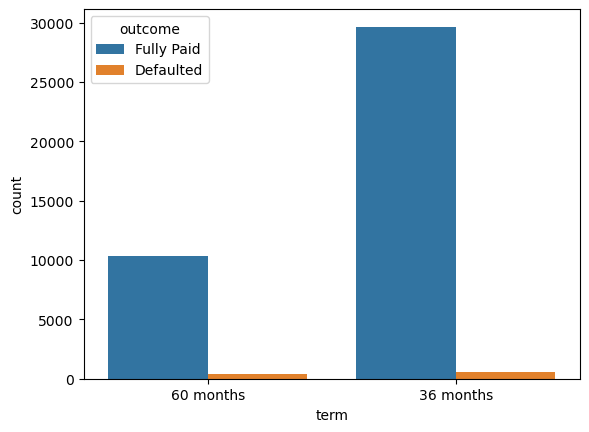

In [8]:
sns.countplot(x='term', hue='outcome', data=df)

Countplot shows a fairly even amount in defaulted loans regardless of time period customer has to pay company back. It also shows there's a lot more 36 month loans opposed to 60 month loans.

### 'Home Ownership' Feature


<Axes: xlabel='home_ownership', ylabel='count'>

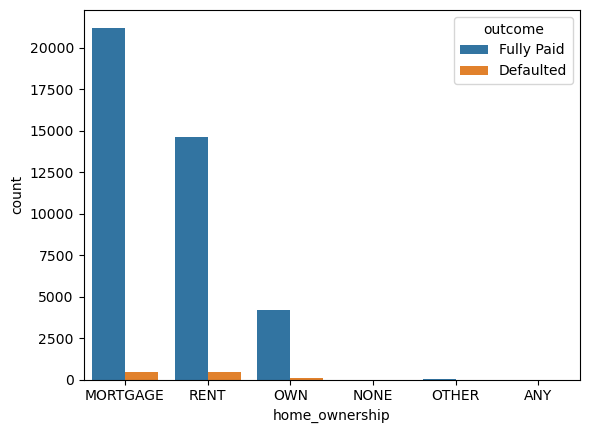

In [9]:
sns.countplot(x="home_ownership", hue="outcome", data=df) # as shown below majority of people with loan have 
# mortgage or rent, and a smaller amount own.

### 'Purpose' feature

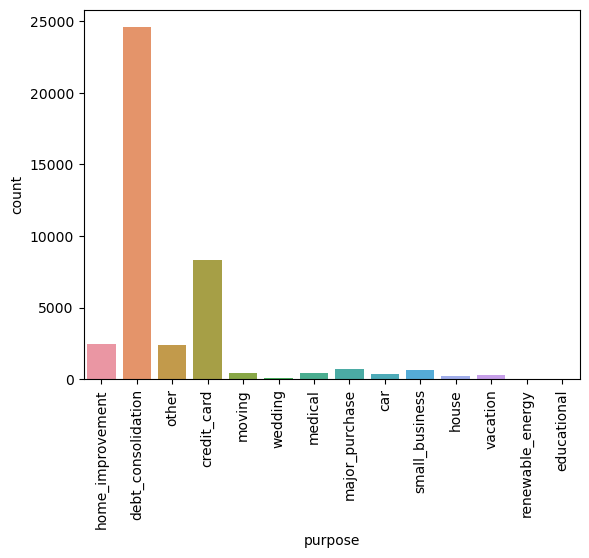

In [10]:
sns.countplot(x="purpose",data=df);
plt.xticks(rotation=90); # below graph shows majority took out loan for debt consolidation

# Preprocessing 

After further analysis of numerous columns within the original dataset and considering the time constraints, I opted to narrow down our feature selection to only a subset of the initial data frame for constructing our model.

This decision was influenced by the observation that many columns contained similar information pertaining to the financial history of individuals. While it's essential to acknowledge the potential impact that various columns can have on an ML model and how certain features may enhance its performance, I believed that starting with the selected features outlined in the code cell below would provide a solid foundation. Should the model's accuracy fall short of expectations, we can readily revisit this decision and incorporate additional columns as needed.


**Pre-processing steps:**

- Select variables to base model off
- Check for missing data and decide whether to drop or impute. We will impute with median as it's more robust against outliers in comparison to the mean.
- Encode non-numeric data
- Normalise numeric data

In [11]:
selected_columns = ['loan_amnt', 'term', 'home_ownership',
                    'annual_inc', 'outcome', 'purpose', 'addr_state']

df_selected = df[selected_columns]

In [12]:
df = df_selected
df.head()

,loan_amnt,term,home_ownership,annual_inc,outcome,purpose,addr_state
0,16075.0,60 months,MORTGAGE,50289.0,Fully Paid,home_improvement,SC
1,8000.0,36 months,MORTGAGE,64000.0,Fully Paid,debt_consolidation,IN
2,23700.0,36 months,RENT,88000.0,Fully Paid,debt_consolidation,FL
3,1200.0,36 months,MORTGAGE,81000.0,Fully Paid,other,NY
4,3500.0,36 months,RENT,11736.0,Fully Paid,debt_consolidation,WA


In [13]:
df.shape

(41029, 7)

In [14]:
missing_data = df.isna().sum()

# Sort the columns based on the number of NaN values in descending order
missing_data_desc = missing_data.sort_values(ascending=False)

# Display the sorted columns
print(missing_data_desc)

loan_amnt         23
term               0
home_ownership     0
annual_inc         0
outcome            0
purpose            0
addr_state         0
dtype: int64


In [15]:
df.dtypes 

loan_amnt         float64
term               object
home_ownership     object
annual_inc        float64
outcome            object
purpose            object
addr_state         object
dtype: object

In [16]:
# creating a list of all non-numeric columns
non_numeric_columns = []

for column in df.columns:
    if df[column].dtype == "object":
         non_numeric_columns.append(column)

print(non_numeric_columns)

['term', 'home_ownership', 'outcome', 'purpose', 'addr_state']


### Encoding 

In [17]:
# encoding non-numeric columns, excluding 'outcome' because it's our target variable
df = pd.get_dummies(df, columns=['term', 'home_ownership', 'purpose', 'addr_state'], drop_first=True)
df.head()

,loan_amnt,annual_inc,outcome,term_60 months,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,16075.0,50289.0,Fully Paid,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8000.0,64000.0,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23700.0,88000.0,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,81000.0,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3500.0,11736.0,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Imputing

In [18]:
loan_amnt_median = df['loan_amnt'].median()
df['loan_amnt'].fillna(loan_amnt_median, inplace=True)

In [19]:
df.head()

,loan_amnt,annual_inc,outcome,term_60 months,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,16075.0,50289.0,Fully Paid,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8000.0,64000.0,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23700.0,88000.0,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,81000.0,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3500.0,11736.0,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
df["loan_amnt"].isna().value_counts() # double checking we've filled all missing rows of data

False    41029
Name: loan_amnt, dtype: int64

### Normalisation

In [21]:
numerical_features = ["annual_inc", "loan_amnt"]
features_to_scale = df[numerical_features]

# Use StandardScaler to normalise the features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(features_to_scale)

In [22]:
df.head()

,loan_amnt,annual_inc,outcome,term_60 months,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,-0.034307,-0.483247,Fully Paid,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.861835,-0.260851,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.747104,0.128434,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.558700,0.014892,Fully Paid,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.322995,-1.108585,Fully Paid,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [23]:
df.shape

(41029, 71)

# Building our model

- Firstly we'll define X and y
- Then perform **under sampling** to rebalance dataset due to class imbalance in feature variable.
- Thereafter, we'll split between train and test datasets. 
- Lastly we'll define a function for fitting models and house list of models we're using in a dictionary. 

### Define X and y

In [24]:
X = df.drop("outcome", axis=1)
y = df["outcome"]

### Under sampling 

First we need to pip install imbalanced-learn

In [25]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [26]:
from imblearn.under_sampling import NearMiss

# Initialize NearMiss
nm = NearMiss()

# Fit and resample the data
X_res, y_res = nm.fit_resample(X, y)

In [27]:
# reassigning name of X and y to undersampled dataset for ease of use
X = X_res
y = y_res

### Train, test, split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 70), (400, 70), (1600,), (400,))

### Building our model

In [30]:
logistic_regression_model = LogisticRegression(max_iter=1000)
random_forest_model = RandomForestClassifier()
svc_model = SVC()
gaussian_nb_model = GaussianNB()

# shuffle the DataFrame
df_shuffled = df.sample(frac=1)

# add models to dictionary
models = {"Logisical Regression": LogisticRegression(max_iter=1000),
          "Random Forest": RandomForestClassifier(),
          "Support Vector Classifier": SVC(),
          "Gaussian Naive Bayes": GaussianNB()}



def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fit and evaluate given machine learning models.
    models: a dictionary of different sklearn machine learning models.
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    '''
    # Make dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to training data
        model.fit(X_train, y_train)
        # Evaluate model on training data
        train_score = model.score(X_train, y_train)
        # Evaluate model on testing data
        test_score = model.score(X_test, y_test)
        # Store scores in model_scores dictionary
        model_scores[name] = {'train_score': train_score, 'test_score': test_score}
        # Print scores
        print(f"{name} Training Accuracy: {train_score:.2f}")
        print(f"{name} Testing Accuracy: {test_score:.2f}")
        print()
    return model_scores

In [31]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

Logisical Regression Training Accuracy: 0.86
Logisical Regression Testing Accuracy: 0.89

Random Forest Training Accuracy: 0.99
Random Forest Testing Accuracy: 0.90

Support Vector Classifier Training Accuracy: 0.89
Support Vector Classifier Testing Accuracy: 0.89

Gaussian Naive Bayes Training Accuracy: 0.75
Gaussian Naive Bayes Testing Accuracy: 0.76



# Model results

Clearly Random Forest performs best. 

In code cells below, we now inspect predictions against truth labels.

In [32]:
random_forest_model.fit(X_train, y_train)  
rf_predictions = random_forest_model.predict(X_test) 

rf_predictions[:50]

array(['Defaulted', 'Fully Paid', 'Defaulted', 'Fully Paid', 'Fully Paid',
       'Fully Paid', 'Defaulted', 'Defaulted', 'Fully Paid', 'Fully Paid',
       'Defaulted', 'Fully Paid', 'Fully Paid', 'Fully Paid',
       'Fully Paid', 'Defaulted', 'Fully Paid', 'Fully Paid', 'Defaulted',
       'Fully Paid', 'Defaulted', 'Defaulted', 'Fully Paid', 'Fully Paid',
       'Fully Paid', 'Defaulted', 'Fully Paid', 'Fully Paid',
       'Fully Paid', 'Fully Paid', 'Defaulted', 'Defaulted', 'Defaulted',
       'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid',
       'Fully Paid', 'Fully Paid', 'Defaulted', 'Fully Paid', 'Defaulted',
       'Fully Paid', 'Fully Paid', 'Defaulted', 'Fully Paid',
       'Fully Paid', 'Defaulted', 'Defaulted', 'Fully Paid'], dtype=object)

In [33]:
y_test[:50]

846      Defaulted
1836    Fully Paid
345      Defaulted
1654    Fully Paid
1563    Fully Paid
1752    Fully Paid
280      Defaulted
56       Defaulted
769      Defaulted
1862    Fully Paid
324      Defaulted
1443    Fully Paid
1466    Fully Paid
1057    Fully Paid
1549    Fully Paid
527      Defaulted
1518    Fully Paid
1018    Fully Paid
276      Defaulted
1324    Fully Paid
834      Defaulted
659      Defaulted
1940    Fully Paid
1375    Fully Paid
1204    Fully Paid
1984    Fully Paid
1017    Fully Paid
1070    Fully Paid
1127    Fully Paid
1350    Fully Paid
633      Defaulted
338      Defaulted
254      Defaulted
1456    Fully Paid
168      Defaulted
1056    Fully Paid
983      Defaulted
1006    Fully Paid
1209    Fully Paid
554      Defaulted
732      Defaulted
52       Defaulted
1255    Fully Paid
1915    Fully Paid
604      Defaulted
1534    Fully Paid
423      Defaulted
909      Defaulted
557      Defaulted
927      Defaulted
Name: outcome, dtype: object

# Hyperparameter tuning

We'll explore both `GridSearchCV` and `RandomizedSaerchCV`.


#### First we create grid oh hyperparameters for random forest

In [34]:
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}


### RandomizedSearchCV

In [35]:
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter = 16,
                          verbose=True)

# fit hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [36]:
rs_rf.score(X_test, y_test)

0.905

### GridSearchCV

In [37]:
gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid=rf_grid,
                     cv=5,
                     verbose=True)

# fit grid hyperparameter search model for RandomForestClassifier
gs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [38]:
rs_rf.score(X_test, y_test)

0.905

**we have achieved 90% accuracy**

# Model Evaluation 

- ROC Curve
- Confusion matrix
- Classification report

These are all very important to analyse, especially considering our imbalanced dataset. The accuracy score isn't enough to go off. The `macro average` indicates the model is working well. 

Other metrics on classification report, confusion matrix and ROC Curve below, show we have a strong foundational model. 

### ROC Curve



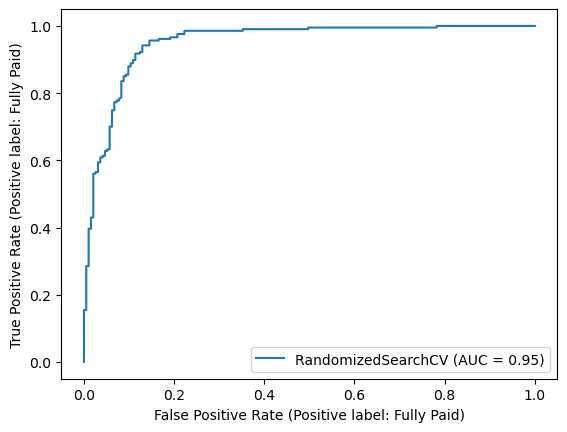

In [39]:
# from_estimator() = use a model to plot ROC curve on data
RocCurveDisplay.from_estimator(estimator=rs_rf, 
                               X=X_test, 
                               y=y_test); 

AUC score of 0.95.

### Confusion Matrix

In [40]:
# confusion matrix 
print(confusion_matrix(y_test, rf_predictions))

[[166  27]
 [ 16 191]]


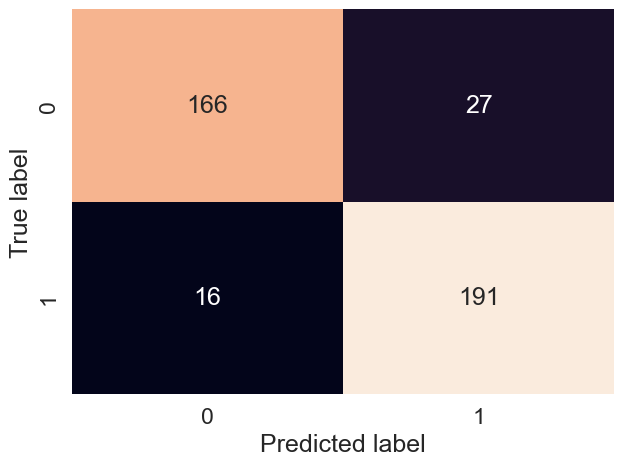

In [41]:
sns.set(font_scale=1.5)  # Increase font size
 
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(7, 5))  # Adjust the figure size as needed
    cm = confusion_matrix(y_test, y_preds)  # Calculate confusion matrix
    ax = sns.heatmap(cm, 
                     annot=True,  # Annotate the boxes
                     fmt='d',    # Display numbers as integers
                     cbar=False) 
    plt.xlabel("Predicted label")  # Predictions go on the x-axis
    plt.ylabel("True label")       # True labels go on the y-axis 

plot_conf_mat(y_test, rf_predictions)


### Classification Report

In [42]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

   Defaulted       0.91      0.86      0.89       193
  Fully Paid       0.88      0.92      0.90       207

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



# Conclusions:

We built a model with 90% accuracy. We could add more columns from our initial dataset to further enhance results.